### Multivariate Linear Regression
#### Published 2010, 2012. 


In [2]:
# Imports
%matplotlib inline
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from IPython import display
import time
import math
from scipy.interpolate import griddata



In [3]:
#Load in data sets

#outline_points = np.loadtxt(r'C:\PyLearn\frac_data\survey_corners', dtype='int')
#trc_data = np.loadtxt(r'C:\PyLearn\frac_data\trc_data_py.txt', dtype='int')
#amp_data = np.loadtxt(r'C:\PyLearn\frac_data\amp_data_cap_py')

outline_points = np.loadtxt(r'C:\Users\Duxvader\dux_python\data\survey_corners', dtype='int')
trc_data = np.loadtxt(r'C:\Users\Duxvader\dux_python\data\trc_data_py', dtype='int')
amp_data = np.loadtxt(r'C:\Users\Duxvader\dux_python\data\amp_data_cap_py')


In [4]:
print("trace data loaded:")
print(trc_data[:,0:-2])
print("size of trc data:", trc_data.shape)
print("sample amp data:", amp_data)

print("first cmp:", np.min(trc_data[:,0]), "last cmp:", np.max(trc_data[:,0]))


trace data loaded:
[[105786     80     46 ...,    114      1      1]
 [105788     80    226 ...,    116      1      2]
 [105790    239    226 ...,    118      1      3]
 ..., 
 [ 68607    159    226 ...,    231    882    984]
 [ 68609    319    226 ...,    233    882    985]
 [ 68611    479    226 ...,    235    882    986]]
size of trc data: (194854, 9)
sample amp data: [ 0.        0.        0.014728 ...,  0.        0.        0.021135]
first cmp: 68490 last cmp: 105824


TRC Geometry File order:

CMP# | OFFSET | AZIMUTH | I-Line# | X-Line# | SIN# | SRF# | CDPX_COORD | CDPY_COORD

Now we can assess the distribution of offset and azimuth available.  Note the longer offset data (>2500m) is centered on 48° and 228°, 180° appart.  These bands will provide the higher incidence angle values.  The survey is well sampled in azimuth out to 1500m.

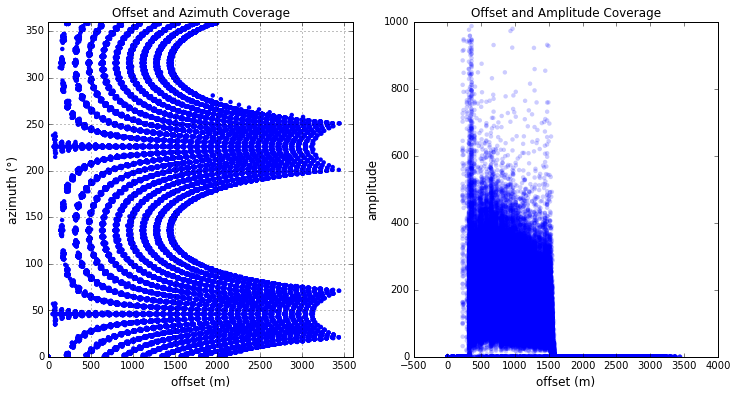

In [5]:
fig1, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(trc_data[:,1],trc_data[:,2], edgecolor='none')
ax[0].set_xlabel('offset (m)', size=12)
ax[0].set_ylabel('azimuth (°)', size=12)
ax[0].set_xlim(0,3600)
ax[0].set_ylim(0,360)
ax[0].set_title('Offset and Azimuth Coverage', size=12)
ax[0].grid()

ax[1].scatter(trc_data[:,1],amp_data*10000, edgecolor='none', alpha=0.2)
ax[1].set_ylim(0,1000)
ax[1].set_xlabel('offset (m)', size=12)
ax[1].set_ylabel('amplitude', size=12)
ax[1].set_title('Offset and Amplitude Coverage', size=12)
plt.show()


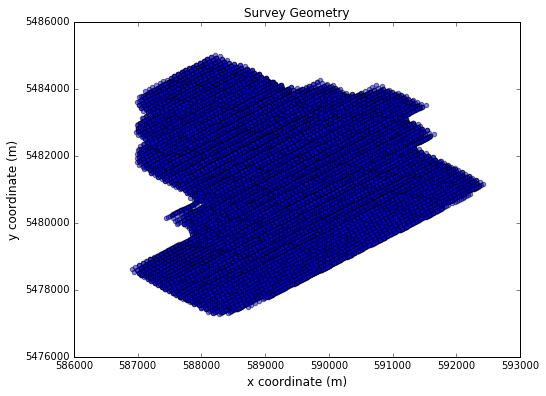

In [6]:
fig1, ax = plt.subplots(figsize=(8,6))
ax.scatter(trc_data[:,7],trc_data[:,8], alpha=0.5)
ax.set_title('Survey Geometry', size=12)
ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
plt.show()

Valid amplitude data appears to be limited to the 400m - 1500m offset range.  
Concentration of high amplitudes at near offset values.  
Amplitude values over 600 likely erroneous.  

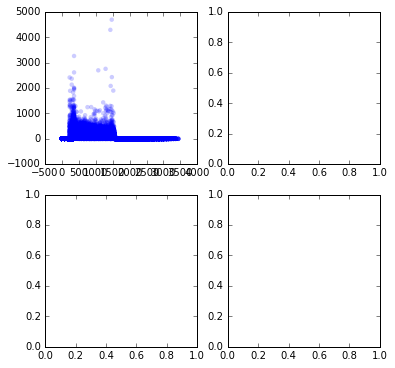

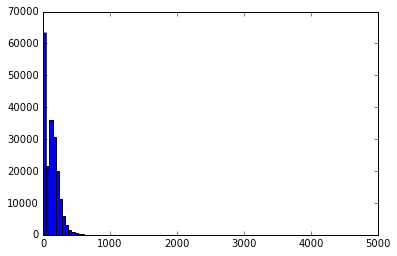

In [7]:
fig2, ax = plt.subplots(2,2,figsize=(6,6))
ax[0,0].scatter(trc_data[:,1],amp_data*10000, edgecolor='none', alpha=0.2)
# ax[0].set_xlabel('offset (m)', size=12)
# ax[0].set_ylabel('amplitude', size=12)
# ax[0].set_xlim(0,3600)
# ax[0].set_ylim(0,1000)

plt.show()

plt.hist(amp_data*10000, bins=100)
plt.show()


Task List
1. Preliminary data analysis, remove outliers
1. Determine data limits to set analysis parameters
2. Loop through each bin, pull in amplitudes at their corresponding offset and azimuth, these will form a surface.  We'll look to perform a linear regression fit of amplitudes for given offset and azimuth according to a fractured medium model.
3. Plot data as visual QC to ensure correct functionality ahead of calculation.
4. Calculate surface fit, store the solution, uncertainty and parameters for each cdp bin


In [8]:
# Task 1 - Parameters

# Set step size and grouping dimensions
cdp_step = 1 #calculate every 4th cdp
cdp_bs = 1 #Primary bin ± 2, which will be a 5x5 super bin size

#Approximate earth parameters
vint = 5130 # interval velocity of target horizon.
vrms = 2700 #rms velocity at target horizon
to = 1.100 #zero offset time in seconds

Inputs for the fractured medium calculation consist of a spatial components (x,y) in meters, sampling azimuth in degrees and a measure of reflected energy or amplitude.

In [9]:
# Task 1.1 - data prep, combine trc_data and amp_data, add an aditional column and merge arrays.
n = len(trc_data); p = trc_data.shape[1] # get the length 'n' and number of columns 'p'
temp_mat = np.zeros((n,p+1)) # add an additional column to zeros matrix
temp_mat[:,9] = amp_data*10000 # add in amplitudes x10000, preserve precision when converted to int later
temp_mat[:,0:9] = trc_data # add in trc_data
temp_mat = temp_mat.astype(int) # easier to read as int

print("Initial trc set length:", len(temp_mat))
amp_fit = temp_mat[:,-1]
amp_mean = np.mean(amp_fit)
amp_std = np.std(amp_fit)

#temp_mat = temp_mat[np.logical_and(amp_fit<amp_mean+6*amp_std, amp_fit>amp_mean-6*amp_std)]
temp_mat = temp_mat[(temp_mat[:,-1]>20) & (temp_mat[:,-1]<400)]
temp_mat = temp_mat[np.logical_and(temp_mat[:,1]>520, temp_mat[:,1]<1600)]
print("Amplitude filter trc set length:", len(temp_mat))

trc_sort = temp_mat[temp_mat[:,0].argsort()] #sort by cdp#


for i in range(trc_sort.shape[0]):
    if trc_sort[i,2]>180: 
        trc_sort[i,2]=trc_sort[i,2]-180
print(trc_sort.shape)

print("first cmp:", np.min(trc_sort[:,0]), "last cmp:", np.max(trc_sort[:,0]))

Initial trc set length: 194854
Amplitude filter trc set length: 118783
(118783, 10)
first cmp: 68490 last cmp: 105816


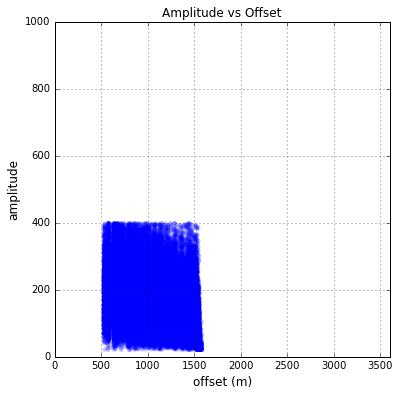

In [10]:
fig3, frame = plt.subplots(figsize=(6,6))
main = frame.scatter( temp_mat[:,1], temp_mat[:,-1], edgecolor='none', alpha=0.2)
frame.set_xlabel('offset (m)', size=12)
frame.set_ylabel('amplitude', size=12)
frame.set_xlim(0,3600)
frame.set_ylim(0,1000)

frame.set_title('Amplitude vs Offset', size=12)
frame.grid()
plt.show()


TRC Geometry File order:
CMP# | OFFSET | AZIMUTH | I-Line# | X-Line# | SIN# | SRF# | CDPX_COORD | CDPY_COORD

In [11]:
%%time
# Task 2 - The meat.  Loop and get it done.

# Set starting values based on inputs
i_line = np.min(trc_sort[:,3]) #first iline position
x_line = np.max(trc_sort[:,4]) #first xline position
i_line_max = np.max(trc_sort[:,3]) #last iline
x_line_max = np.max(trc_sort[:,4]) #last xline
cdp_n = np.min(trc_sort[:,0]) # first cmp position in data
first_cdp = np.min(trc_sort[:,0])
position = 0
last_cdp = np.max(trc_sort[:,0]) #last cmp position in data
print("start:",first_cdp)
print("end:",last_cdp)

# get unique cmp numbers and their indices
unique_cmp, cmp_indices = np.unique(trc_sort[0:100000,0], return_index=True)
len_cmp = len(unique_cmp)
# create an empty array to store the output for each cmp location, size is number of cmp locations in data
out_soln = np.empty([last_cdp-first_cdp,trc_sort.shape[1]])

# loop through a subset or all of the cmp locations
for n_cdp in range(0,len_cmp,cdp_step):
    
    # Get the current inline and xline values, (x,y) coordinates
    current_cdp = trc_sort[trc_sort[:,0]==unique_cmp[n_cdp]] # returns an array of all traces matching current cdp number
    il = current_cdp[0,3]; xl = current_cdp[0,4] # select the location properties from the first trace 
    cmp_x = current_cdp[0,7]; cmp_y = current_cdp[0,8] # select the location properties from the first trace 
    
    # For a cmp location, select surrounding cmps according to the super bin size
    cdp_trc = trc_sort[(trc_sort[:,3] >= (il-2*cdp_bs)) & (trc_sort[:,3] <= (il+2*cdp_bs)) 
                       & (trc_sort[:,4] >= (xl-2*cdp_bs)) & (trc_sort[:,4] <= (xl+2*cdp_bs)) ]  
    # Surface Fitting
    # Step 1. Data prep.
    # amplitude
    amp_fit = cdp_trc[:,-1].reshape(len(cdp_trc),1)

    # offset in terms of sin(theta)^2
    off_fit = cdp_trc[:,1]/2 # take 1/2 the src-rec offset
    off_fit = ((vint/vrms)*(off_fit/(np.sqrt(off_fit**2+(to**2*vrms**2)))))**2 # offset in terms of sin(theta)^2, theta = incidence angle
    off_tansqr = np.tan(np.arcsin(np.sqrt(off_fit)))**2 # offset in terms of tan(theta)^2, theta = incidence angle
    
    # azimuth
    azm_fit = cdp_trc[:,2]
    
    # Determine Regression Coefficients
    pi = math.pi/180
    avoa_fit = np.array([np.ones(len(amp_fit)), (np.cos(azm_fit*pi)**2)*off_fit,
                np.cos(azm_fit*pi)*np.sin(azm_fit*pi)*off_fit*2,
                (np.sin(azm_fit*pi)**2)*off_fit, off_fit*off_tansqr]) # 4th term  off_fit*off_tansqr - removed
    avoa_fit=avoa_fit.T
    avoa_coefs,resid,rank,s = np.linalg.lstsq(avoa_fit,amp_fit) # least squares regression.
    
    # Calculate the errors on the surface fit, observed amplitudes comapred to modeled amplitudes
    
    n = np.max(amp_fit.shape) # number of samples
    amp_model = np.dot(avoa_fit,avoa_coefs)
    residuals = amp_fit - amp_model #observed amplitudes - model surface fit amplitude
    RSS = sum(residuals**2) # sum of squared residuals
    TSS = sum((amp_fit-np.mean(amp_fit))**2) # total sum of squares
    R2 = 1 - RSS/TSS # r squared
    std_error = np.sqrt(RSS/(n-len(avoa_coefs)))
    std_y = np.sqrt(TSS/(n-1))
    R2_adj = 1 - (std_error/std_y)**2  # adjusted R squared
    
    # Calculate the modeled azimuth from the regression fit
    frac_az = np.arctan(((avoa_coefs[1]-avoa_coefs[3])+np.sqrt((avoa_coefs[1]-avoa_coefs[3])**2+(avoa_coefs[2]**2)*4))/(avoa_coefs[2]*2))
    frac_az = frac_az*(180/np.pi) # convert to degrees
    
    # flip all values to zero - 180 degrees
    if frac_az>180:
        frac_az = frac_az - 180
    
    # Calculate the modeled magnitude of anisotropy from the regression fit
    g_aniso = np.sqrt((avoa_coefs[1]-avoa_coefs[3])**2+(avoa_coefs[2]**2)*4)
    
    # Capture the output for plotting later
    out_soln[position,0]=current_cdp[0,0] # cmp number
    out_soln[position,1]=cmp_x # cmp_x coordinate
    out_soln[position,2]=cmp_y # cmp_y coordinate
    out_soln[position,3]=il # inline #
    out_soln[position,4]=xl # xline #
    
    # store the fracture gradient magnitude and orientation azimuth
    out_soln[position,5]=g_aniso
    out_soln[position,6]=frac_az
    
    # store the associated adjusted R squared value
    out_soln[position,7]=R2
    
    # Increment output position index
    position +=1
    
    
    
    
print("Crunched",position,"super cmp bins")    
    

start: 68490
end: 105816
Crunched 6117 super cmp bins
Wall time: 18.8 s


Unruly CMP gathers: 6117
After removing NaNs 6117
After negative correlations 6117
After erroneous gradients 6064


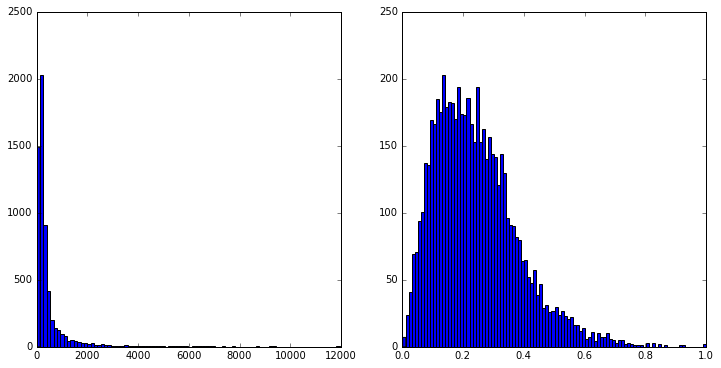

In [12]:
out_clean = out_soln[out_soln[:,0]!=0]
print("Unruly CMP gathers:",out_clean.shape[0])
out_clean = out_clean[~np.isnan(out_clean).any(axis=1)]
print("After removing NaNs",out_clean.shape[0])
out_clean = out_clean[out_clean[:,7]>0]
print("After negative correlations",out_clean.shape[0])
out_clean = out_clean[out_clean[:,5]<12000]
print("After erroneous gradients",out_clean.shape[0])


## QC cell
fig2,ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(out_clean[0:position,5], bins = 90)
ax[1].hist(out_clean[0:position,7], bins = 100)
plt.show()

min cmp: 68491.0
max cmp: 93363.0


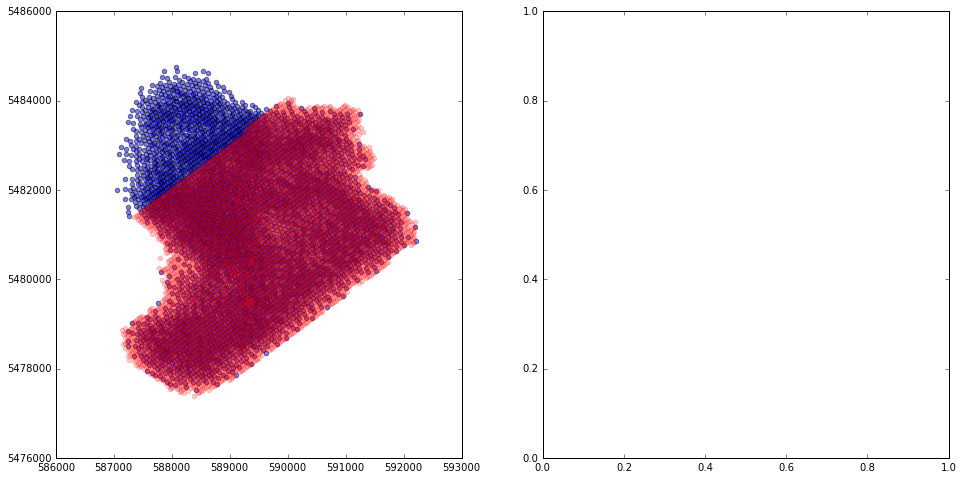

In [13]:

print("min cmp:",np.min(out_clean[:,0]))
print("max cmp:",np.max(out_clean[:,0]))
fig2,ax = plt.subplots(1,2, figsize=(16,8))
ax[0].scatter(trc_sort[::20,7],trc_sort[::20,8], alpha=0.5)
ax[0].scatter(out_clean[:,1],out_clean[:,2], color='red', alpha=0.2) #Plot cmp x,y coords

plt.show()

#### Visualizing the Output

Now we'll look to create plots of the results and maps of the spatial data.

length of output: 6064


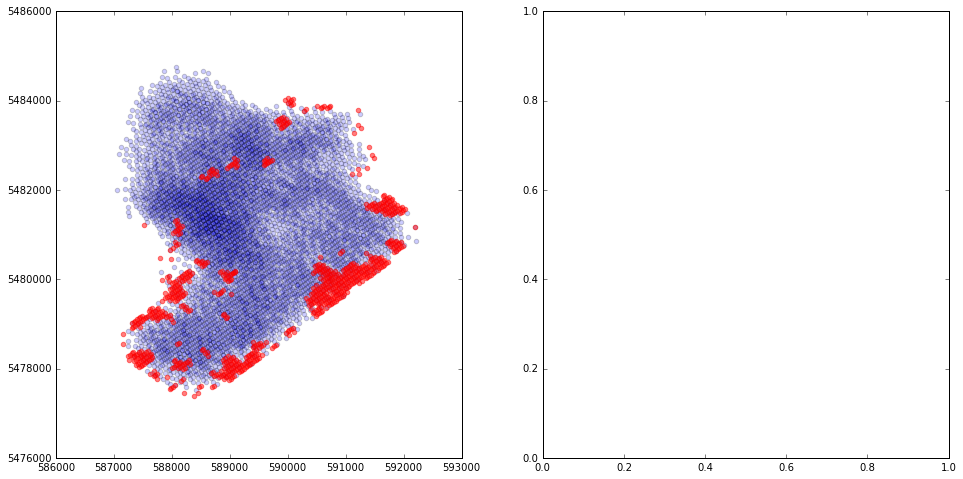

In [14]:
# Visual Summary of Crunched CMP super gathers

print("length of output:",len(out_clean))

fig2,ax = plt.subplots(1,2, figsize=(16,8))

ax[0].scatter(trc_sort[::20,7],trc_sort[::20,8], alpha=0.2)
ax[0].scatter(out_clean[out_clean[:,7]>0.4][:,1],out_clean[out_clean[:,7]>0.4][:,2],alpha=0.5, color='red') #Plot cmp x,y coords

plt.show()

Plot data distribution for the super binned traces

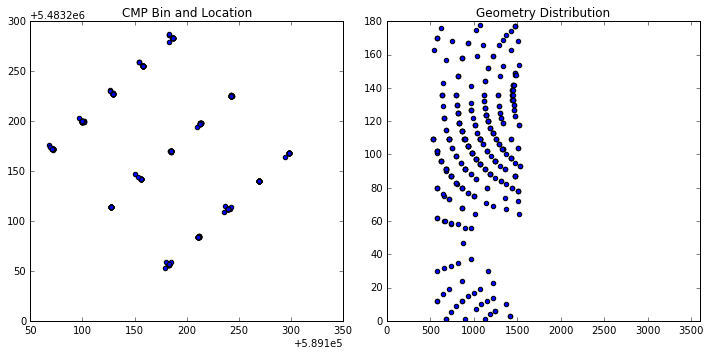

In [15]:
fig2,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(cdp_trc[:,7],cdp_trc[:,8])
#ax[0].plot(outline_points[:,0],outline_points[:,1])
ax[0].set_title('CMP Bin and Location')

ax[1].scatter(cdp_trc[:,1],cdp_trc[:,2])
ax[1].set_title('Geometry Distribution')
ax[1].set_xlim(0,3600)
ax[1].set_ylim(0,180)


plt.tight_layout()
plt.show()



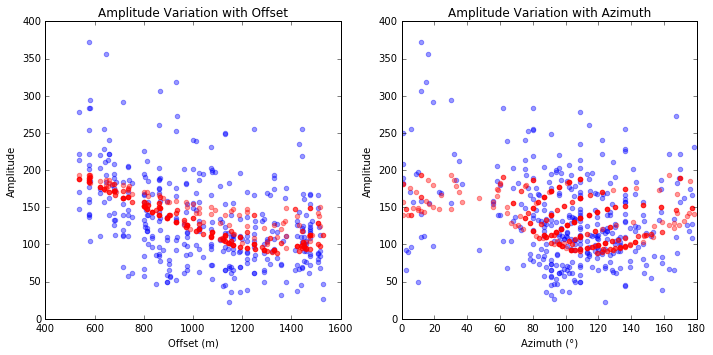

In [16]:
fig2,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(cdp_trc[:,1],cdp_trc[:,9], color='blue',alpha=0.4)
ax[0].scatter(cdp_trc[:,1],amp_model, color='red',alpha=0.4)
#ax[0].plot(outline_points[:,0],outline_points[:,1])
ax[0].set_title('Amplitude Variation with Offset')
ax[0].set_xlabel('Offset (m)')
ax[0].set_ylabel('Amplitude')

ax[1].scatter(cdp_trc[:,2],cdp_trc[:,9], color='blue',alpha=0.4)
ax[1].scatter(cdp_trc[:,2],amp_model, color='red',alpha=0.4)
ax[1].set_xlim(0,180)
ax[1].set_title('Amplitude Variation with Azimuth')
ax[1].set_xlabel('Azimuth (°)')
ax[1].set_ylabel('Amplitude')


plt.tight_layout()
plt.show()


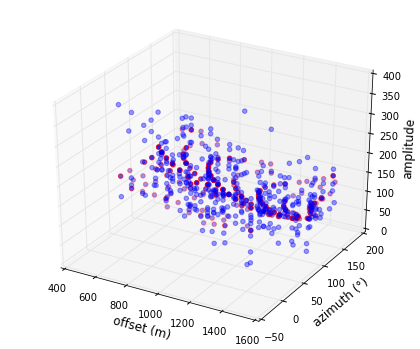

In [17]:
fig=plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(cdp_trc[:,1],cdp_trc[:,2], cdp_trc[:,9],color='blue', alpha=0.4 ) 
ax.scatter(cdp_trc[:,1],cdp_trc[:,2], amp_model, color='red', alpha=0.4) 
ax.set_xlabel('offset (m)', size=12)
ax.set_ylabel('azimuth (°)', size=12)
ax.set_zlabel('amplitude', size=12)

plt.show()



shape of x (351,)


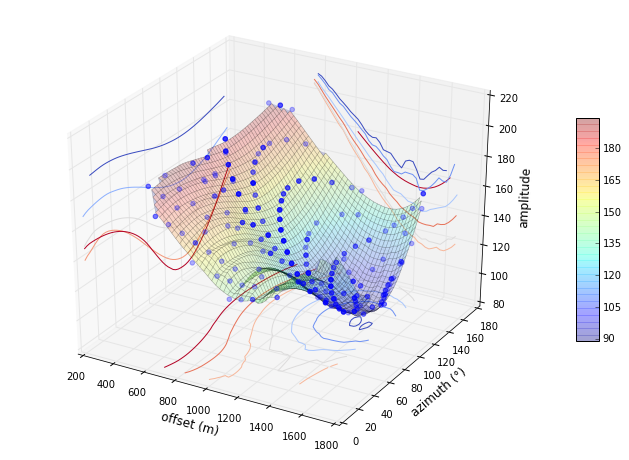

In [18]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection='3d')

x=np.reshape(cdp_trc[:,1],len(cdp_trc[:,1]))
print('shape of x',x.shape)
y = np.reshape(cdp_trc[:,2],len(cdp_trc[:,2]))
#print('shape of y',y.shape)
z = np.reshape(amp_model,len(amp_model))

## OK! so the problem is in duplicate coordinates? anyway, you find unique indices for B and then sample them from z

#B = [x,y]
#B,I,J = np.unique(B,'rows','first')
#print('shape of B', B.shape)
#z = z[I]

#print('shape of z',z.shape)
#print('amp model shape',amp_model.shape)
xlin = np.linspace(400,1600,50)
ylin = np.linspace(0,180,60)
X,Y = np.meshgrid(xlin,ylin)
#print('X shape', X.shape)
Z = griddata((x,y),z,(X,Y),method='cubic')
#print(Z.shape)

# find min/max of Z for color bar scaling since the gridded data will contain nans that 
# throw off the color scaling
zmin = Z[np.where(np.isnan(Z) == False)].min()
zmax = Z[np.where(np.isnan(Z) == False)].max()

cset = ax.contour(X, Y, Z, zdir='z', offset=80, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=200, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=220, cmap=cm.coolwarm)
surf = ax.plot_surface(X, Y, Z, rstride=1,cstride=1,cmap=cm.jet,
                       linewidth=0.5, antialiased=True, alpha=0.2, vmin=zmin, vmax=zmax, edgecolors='black')

ax.scatter(cdp_trc[:,1],cdp_trc[:,2], amp_model, color='blue', alpha=0.3) 

fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_xlim(200,1800)
ax.set_ylim(0,180)
ax.set_zlim(80,220)
ax.set_xlabel('offset (m)', size=12)
ax.set_ylabel('azimuth (°)', size=12)
ax.set_zlabel('amplitude', size=12)


plt.show()

In [19]:
# Setup plotting data and grid parameters
# out_solution x,y,magnitude,azimuth (1,2,5,6)
x=np.reshape(out_clean[:,1],len(out_clean[:,1]))
y = np.reshape(out_clean[:,2],len(out_clean[:,2]))
z = np.reshape(out_clean[:,5],len(out_clean[:,5]))

xlin = np.linspace(np.min(x),np.max(x),int((np.max(x)-np.min(x))/100))
ylin = np.linspace(np.min(y),np.max(y),int((np.max(y)-np.min(y))/100))
X,Y = np.meshgrid(xlin,ylin)
binsize=50
Z = griddata((x,y),z,(X,Y),method='cubic')

zmin = Z[np.where(np.isnan(Z) == False)].min()
zmax = Z[np.where(np.isnan(Z) == False)].max()

print('shape of gird Z',Z.shape)
zi, yi, xi = np.histogram2d(y, x, bins=Z.shape, weights=z, normed=False)
zi = np.ma.masked_equal(zi, 0)
unit_grid = zi/zi
Z_masked = Z*unit_grid



shape of gird Z (66, 50)


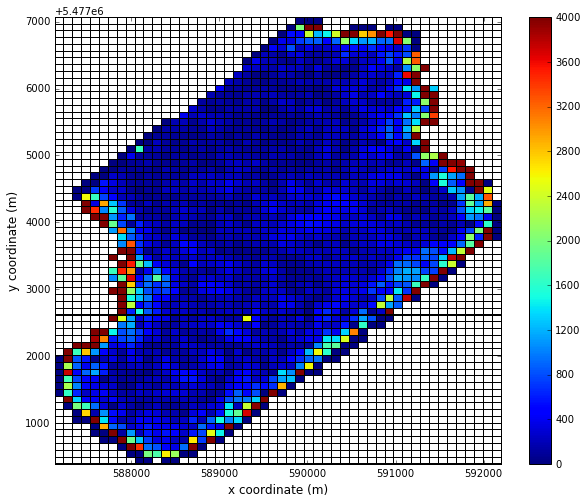

In [20]:

fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
# surf = ax.contourf(X, Y, Z_masked, rstride=1,cstride=1,cmap=cm.jet,
#                        linewidth=0.4, antialiased=True, alpha=0.4,
#                        vmin=zmin, vmax=zmax, edgecolors='black') 

#fig.colorbar(surf,shrink=0.5, aspect=10)
#ax.scatter(x,y, color='blue', alpha=0.3)

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
#ax.view_init(-270,270)
grid_plot = ax.pcolormesh(xi, yi, Z_masked, edgecolors='black',linewidth=0.01,vmin=0, vmax=4000)
ax.axis('tight')
#grid_plot.set_clim(vmin=0,vmax=3000)
fig.colorbar(grid_plot)


plt.show()

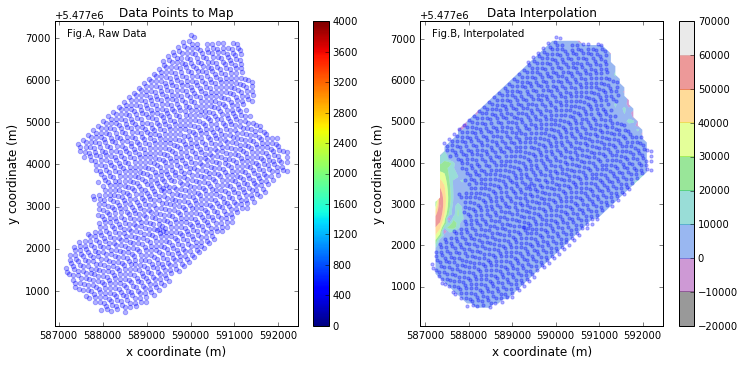

In [21]:
fig=plt.figure(figsize=(12,12))

#/// Upper left - Data Points and Grid
ax = fig.add_subplot(2,2,1)

ax.scatter(x[::4],y[::4], color='blue', alpha=0.3, s=20)
fig.colorbar(grid_plot)
ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Data Points to Map')
ax.annotate('Fig.A, Raw Data',xy=(0.05,0.95),xycoords='axes fraction')
ax.axis('tight')
#///

#/// Upper Right - Grid and color
ax = fig.add_subplot(2,2,2)
surf = ax.contourf(X, Y, Z, rstride=1,cstride=1,cmap='nipy_spectral',
                      linewidth=0.4, antialiased=True, alpha=0.4,
                        vmin=zmin, vmax=zmax, edgecolors='black')
ax.scatter(x[::4],y[::4], edgecolor='blue', facecolor='blue', alpha=0.3, s=10)
fig.colorbar(surf)

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.annotate('Fig.B, Interpolated',xy=(0.05,0.95),xycoords='axes fraction')
ax.set_title('Data Interpolation')

ax.axis('tight')
#///

plt.show()

### Well, time to start digging.

#### Challenges
1. Data is being interpolated in blank areas where there are no measurements
2. The value range is being interpolated to extremes in areas of no data
3. Insights we might gain from local variability are being obscured by the interpolated data range  



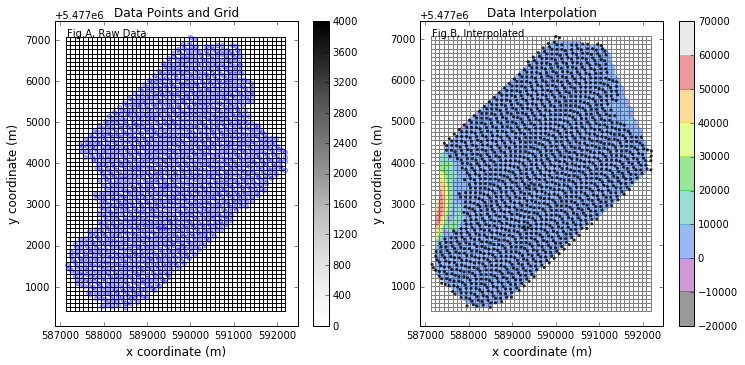

In [22]:
fig=plt.figure(figsize=(12,12))

#/// Upper left - Data Points and Grid
ax = fig.add_subplot(2,2,1)

grid_plot = ax.pcolormesh(xi, yi, np.zeros(Z_masked.shape), edgecolors='black',
                          linewidth=0.005,vmin=0, vmax=4000,cmap='Greys')
ax.scatter(x[::4],y[::4], color='blue', alpha=0.3, s=20)
fig.colorbar(grid_plot)
ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Data Points and Grid')
ax.annotate('Fig.A, Raw Data',xy=(0.05,0.95),xycoords='axes fraction')
ax.axis('tight')
#///

#/// Upper Right - Grid and color
ax = fig.add_subplot(2,2,2)
grid_plot = ax.pcolormesh(xi, yi, np.zeros(Z_masked.shape), edgecolors='grey',
                          linewidth=0.005,vmin=0, vmax=4000,cmap='Greys')
surf = ax.contourf(X, Y, Z, rstride=1,cstride=1,cmap='nipy_spectral',
                      linewidth=0.4, antialiased=True, alpha=0.4,
                        vmin=zmin, vmax=zmax, edgecolors='black')
ax.scatter(x[::4],y[::4], edgecolor='none', facecolor='black', alpha=0.8, s=10)
fig.colorbar(surf)

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.annotate('Fig.B, Interpolated',xy=(0.05,0.95),xycoords='axes fraction')
ax.set_title('Data Interpolation')

ax.axis('tight')
#///

plt.show()

Displaying the grid it is easier to see what's happening here.  
The data is being interpolated between measurements.  
That can be fixed by masking to where we have observation points.  

Where we have observations the data range is consistently in the blue or 0-10,000 range.  
The color bar can be restricted to this range to bring out texture within the observation area.
Additionally, the plotting can be changed from binned colors to a more uniform display range

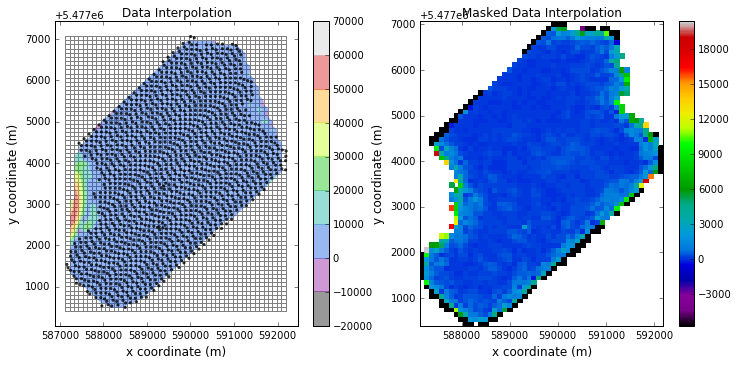

In [23]:
fig=plt.figure(figsize=(12,12))

#/// Upper Left - Grid and color
zmin = Z[np.where(np.isnan(Z) == False)].min()
zmax = Z[np.where(np.isnan(Z) == False)].max()
ax = fig.add_subplot(2,2,1)
grid_plot = ax.pcolormesh(xi, yi, np.zeros(Z_masked.shape), edgecolors='grey',
                          linewidth=0.005,vmin=0, vmax=4000,cmap='Greys')
surf = ax.contourf(X, Y, Z, rstride=1,cstride=1,cmap='nipy_spectral',
                      linewidth=0.4, antialiased=True, alpha=0.4,
                        vmin=zmin, vmax=zmax, edgecolors='black')
ax.scatter(x[::4],y[::4], edgecolor='none', facecolor='black', alpha=0.8, s=10)
fig.colorbar(surf)

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Data Interpolation')

ax.axis('tight')
#///

zmin = Z_masked[np.where(np.isnan(Z_masked) == False)].min()
zmax = Z_masked[np.where(np.isnan(Z_masked) == False)].max()

#/// Upper Right - Grid and color
ax = fig.add_subplot(2,2,2)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='nipy_spectral')
fig.colorbar(surf)

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Masked Data Interpolation')

ax.axis('tight')
#///


plt.show()

Now things are starting to become more clear.  

The extreme values appear to be located on the fringes of the observation points.  
The core of the measured data points have subtle variation within the 0-3000 range.  

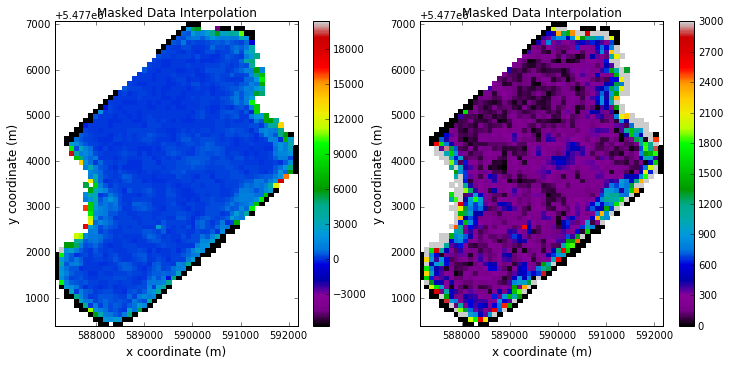

In [24]:
fig=plt.figure(figsize=(12,12))

#/// Upper Left - Grid and color
ax = fig.add_subplot(2,2,1)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='nipy_spectral')
fig.colorbar(surf)

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Masked Data Interpolation')

ax.axis('tight')
#///

#/// Upper right - Color Surf
ax = fig.add_subplot(2,2,2)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=0, vmax=3000,cmap='nipy_spectral')
fig.colorbar(surf)

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Masked Data Interpolation')

ax.axis('tight')
#///

plt.show()

### Getting there.

Now variations within the measured data can be observed (purple to blue).  
Most of the extreme values appear to be concentrated to the edges of observation area.  
This likely occurs because the sampling direction is limited at the boundaries of the survey.  

Next steps.  
1. Remove extreme values
2. Automate color range to filtered values
3. Add in inferred fracture orientations




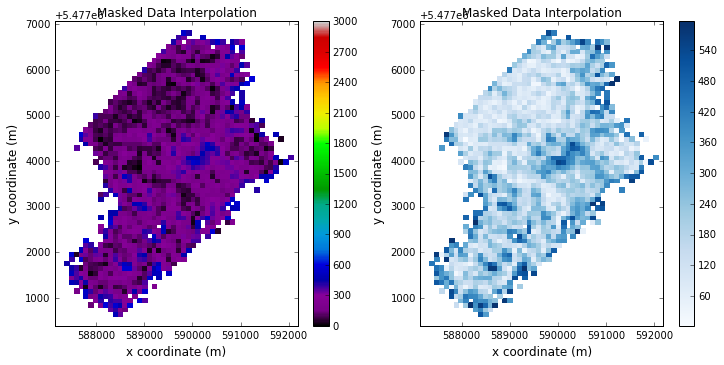

In [29]:
fig=plt.figure(figsize=(12,12))

#/// Upper Left - Color Surf
ax = fig.add_subplot(2,2,1)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=0, vmax=3000,cmap='nipy_spectral')
fig.colorbar(surf)

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Masked Data Interpolation')

ax.axis('tight')
#///

Z_masked[(Z_masked>600)]=np.NaN
Z_masked[(Z_masked<0)]=np.NaN
Z_masked = np.ma.masked_equal(Z_masked, 0)
unit_grid = Z_masked/Z_masked
Z_masked = Z_masked*unit_grid

zmin = Z_masked[np.where(np.isnan(Z_masked) == False)].min()
zmax = Z_masked[np.where(np.isnan(Z_masked) == False)].max()

#/// Upper Left - Color Surf
ax = fig.add_subplot(2,2,2)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='Blues')
fig.colorbar(surf)

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Masked Data Interpolation')

ax.axis('tight')
#///

plt.show()

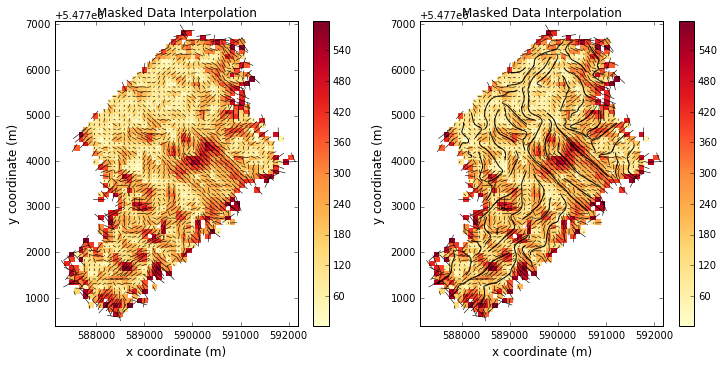

In [34]:
fig=plt.figure(figsize=(12,12))

ax = fig.add_subplot(2,2,1)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='YlOrRd')
fig.colorbar(surf)


# set up the quiver
z_az = out_clean[:,6]
Z_azm = griddata((x,y),z_az,(X,Y),method='cubic')

#print('shape of gird Z',Z.shape)
#zi, yi, xi = np.histogram2d(y, x, bins=Z.shape, weights=z, normed=False)


Z_azm = Z_azm*unit_grid
Z_azm = np.ma.masked_equal(Z_azm, 0)
length = 120 # 50 meters
UN = Z_masked*0.6*np.sin(Z_azm*(np.pi/180))
VN = Z_masked*0.6*np.cos(Z_azm*(np.pi/180))
plt.quiver(X, Y, UN, VN, 
           color='k',angles='xy', scale_units='xy', scale=1, linewidth=0.001,headlength=1, headwidth=1, pivot='middle')
ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Masked Data Interpolation')

ax.axis('tight')
#///


ax = fig.add_subplot(2,2,2)
surf = ax.pcolormesh(xi, yi, Z_masked, edgecolors='none',
                     linewidth=0.005,vmin=zmin, vmax=zmax,cmap='YlOrRd')
fig.colorbar(surf)


# set up the quiver
z_az = out_clean[:,6]
Z_azm = griddata((x,y),z_az,(X,Y),method='cubic')

#print('shape of gird Z',Z.shape)
#zi, yi, xi = np.histogram2d(y, x, bins=Z.shape, weights=z, normed=False)


Z_azm = Z_azm*unit_grid
Z_azm = np.ma.masked_equal(Z_azm, 0)
length = 120 # 50 meters
UN = Z_masked*0.6*np.sin(Z_azm*(np.pi/180))
VN = Z_masked*0.6*np.cos(Z_azm*(np.pi/180))
plt.quiver(X, Y, UN, VN, 
           color='k',angles='xy', scale_units='xy', scale=1, linewidth=0.001,headlength=1, headwidth=1, pivot='middle')
plt.streamplot(X, Y, UN, VN, linewidth=1,         # line thickness
               arrowstyle='-',     # arrow style
               arrowsize=1.5, color = 'black') 

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Masked Data Interpolation')

ax.axis('tight')
#///


plt.show()

In [ ]:
fig=plt.figure(figsize=(12,12))

#/// Upper left - Data Points and Grid
ax = fig.add_subplot(2,2,1)

grid_plot = ax.pcolormesh(xi, yi, np.zeros(Z_masked.shape), edgecolors='black',
                          linewidth=0.005,vmin=0, vmax=4000,cmap='Greys')
ax.scatter(x[::4],y[::4], color='blue', alpha=0.3, s=20)
fig.colorbar(grid_plot)
ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.set_title('Data Points and Grid')
ax.annotate('Fig.A, Raw Data',xy=(0.05,0.95),xycoords='axes fraction')
ax.axis('tight')
#///

#/// Upper Right - Grid and color
ax = fig.add_subplot(2,2,2)
grid_plot = ax.pcolormesh(xi, yi, np.zeros(Z_masked.shape), edgecolors='grey',
                          linewidth=0.005,vmin=0, vmax=4000,cmap='Greys')
surf = ax.contourf(X, Y, Z, rstride=1,cstride=1,cmap='nipy_spectral',
                      linewidth=0.4, antialiased=True, alpha=0.4,
                        vmin=zmin, vmax=zmax, edgecolors='black')
ax.scatter(x[::4],y[::4], edgecolor='none', facecolor='black', alpha=0.8, s=10)
fig.colorbar(surf)

ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)
ax.annotate('Fig.B, Interpolated',xy=(0.05,0.95),xycoords='axes fraction')
ax.set_title('Data Interpolation')

ax.axis('tight')
#///

#/// Upper Right - Grid and color
# ax = fig.add_subplot(2,2,2)
# grid_plot = ax.pcolormesh(xi, yi, Z, edgecolors='grey',
#                           linewidth=0.005,vmin=zmin, vmax=zmax,cmap='Greys')
# ax.scatter(x[::4],y[::4], edgecolor='white', facecolor='white', alpha=0.3, s=10)
# fig.colorbar(grid_plot)

# ax.set_xlabel('x coordinate (m)', size=12)
# ax.set_ylabel('y coordinate (m)', size=12)
# ax.annotate('Fig.B, Interpolated',xy=(0.05,0.95),xycoords='axes fraction')
# ax.set_title('Data Interpolation')

# ax.axis('tight')
#///



#surf = ax.contourf(X, Y, Z_masked, rstride=1,cstride=1,cmap=cm.jet,
#                       linewidth=0.4, antialiased=True, alpha=0.4,
#                        vmin=zmin, vmax=zmax, edgecolors='black')

#fig.colorbar(surf,shrink=0.5, aspect=10)
#ax.scatter(x,y, color='blue', alpha=0.3)


#grid_plot = ax.pcolormesh(xi, yi, Z_masked, edgecolors='black',linewidth=0.01,vmin=0, vmax=4000)
#grid_plot.set_clim(vmin=0,vmax=3000)


ax = fig.add_subplot(2,2,4)
#image plot solution for later.
img = ax.imshow(Z_masked, aspect="auto", origin='lower',vmin=0, vmax=4000)
fig.colorbar(img)
ax.set_xlabel('x coordinate (m)', size=12)
ax.set_ylabel('y coordinate (m)', size=12)


plt.show()

In [ ]:
print("Amp set shape", amp_fit.shape)
amp_mean = np.mean(amp_fit)
amp_std = np.std(amp_fit)
amp_chk = amp_fit[np.logical_and(amp_fit<amp_mean+1.5*amp_std, amp_fit>amp_mean-1.5*amp_std)]
amp_chk = amp_fit.reshape(len(amp_fit),1)
print("Amp set shape", amp_chk.shape)

In [ ]:

print("Coefs:",avoa_coefs)
print("residual:",resid)
print("rank:",rank)
print("s", s)

Error Calculation Block:

In [ ]:
n = np.max(amp_fit.shape) # number of samples
amp_model = np.dot(avoa_fit,avoa_coefs)
residuals = amp_fit - amp_model #observed amplitudes - model surface fit amplitude
RSS = sum(residuals**2) # sum of squared residuals
TSS = sum((amp_fit-np.mean(amp_fit))**2) # total sum of squares
R2 = 1 - RSS/TSS # r squared?
std_error = np.sqrt(RSS/(n-len(avoa_coefs)))
std_y = np.sqrt(TSS/(n-1))
R2_adj = 1 - (std_error/std_y)**2  # adjusted R squared
print("RSS:", RSS, "R sqr:",R2,"Adj R sqr:",R2_adj,"Std_error:",std_error)
plt.scatter(amp_fit,amp_model)
plt.xlabel("Obs")
plt.ylabel("model")
plt.show()

// possibility to improve runtime by limiting range of indexes based on inline and crossline positions

select_indices = np.where( np.logical_and( x > 1, x < 5) )    1 < x <5

select_indices = np.where( np.logical_or( x < 1, x > 5 ) )  x <1 or x >5

// fancy mesh plot http://stackoverflow.com/questions/9152958/matplotlib-3d-plot-2d-format-for-input-data

In [ ]:
plt.scatter(trc_sort[:,0],trc_sort[:,-1])
plt.show()

In [ ]:
a=np.array([1,2,3]); b=np.array([2,2,2])
c=a\b
c

In [ ]:
NumPersons = np.array([[100,175,210],[90,160,150],[200,50,100],[120,0,310]])
Price_per_100_g = np.array([2.98,3.90,1.99])
ans = NumPersons*Price_per_100_g
ans2 = np.dot(NumPersons,Price_per_100_g)

In [ ]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 3, 4, 4, 5])
n = np.max(x.shape)    # the number of observations
X = np.vstack([np.ones(n), x]).T
a = np.linalg.lstsq(X, y)[0]
print(a)

In [ ]:
help(np.std)

In [ ]:
help(np.arctan)
     

In [ ]:
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
h = plt.contourf(x,y,z)

In [ ]:
help(plt.colorbar)

In [ ]:
help(np.histogram2d)

code snipets for later:

Setting 3D plot view perspective:  
ax.view_init(-270,270)  
ax.axis('tight')  

In [ ]:
help(plt.quiver)